In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
data = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv', index_col='date')

In [39]:
data

,pm25,pm10,o3,no2,so2,co
date,,,,,,
3/1/2019,76,1,15,36,7,7
3/2/2019,117,64,4,28,3,5
3/3/2019,10,64,1,22,16,5
3/4/2019,118,56,13,22,14,6
3/5/2019,2,34,15,21,6,6
...,...,...,...,...,...,...
5/28/2024,85,56,14,1,8,6
5/29/2024,58,50,13,1,8,6
5/30/2024,47,39,10,1,8,8


In [40]:
data.fillna(method='ffill', inplace=True)
scaler = MinMaxScaler()
data['pm25'] = scaler.fit_transform(data[['pm25']])

In [41]:
def create_sequences(data, seq_length=30):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(data['pm25'].values, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(seq_length, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [43]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 30)                0         
                                                                 
 dense_18 (Dense)            (None, 128)               3968      
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12289 (48.00 KB)
Trainable params: 12289 (48.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/100
48/48 [==============================] - 1s 10ms/step - loss: 0.0492 - val_loss: 0.0238
Epoch 2/100
48/48 [==============================] - 0s 4ms/step - loss: 0.0171 - val_loss: 0.0223
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0216
Epoch 4/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0141 - val_loss: 0.0214
Epoch 5/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0147 - val_loss: 0.0243
Epoch 6/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0135 - val_loss: 0.0222
Epoch 7/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0128 - val_loss: 0.0219
Epoch 8/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0214
Epoch 9/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0124 - val_loss: 0.0220
Epoch 10/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0120 - val_loss: 0.0224
Epoch 11

In [45]:
# Predict the next 30 days PM2.5 values
last_sequence = X_test[-1]
predictions = []
current_sequence = last_sequence

for _ in range(30):
    next_value = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
    predictions.append(next_value)
    current_sequence = np.append(current_sequence[1:], [[next_value]], axis=0)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print("Next 30 days PM2.5 predictions:", predictions.flatten())

1/1 [==============================] - 0s 20ms/step
Next 30 days PM2.5 predictions: [ 55.159695  59.011055  37.670532  28.83299   52.489227  64.47026
 101.24297   80.171036  84.10558   96.29495   95.24103   87.04141
  78.254265  67.41558   45.669376  63.82546   63.35578   73.95303
  87.00394   84.719536 101.228195 112.783    109.00685  114.14623
  92.6102    74.77384   80.26057   89.012474  69.38206   58.576252]


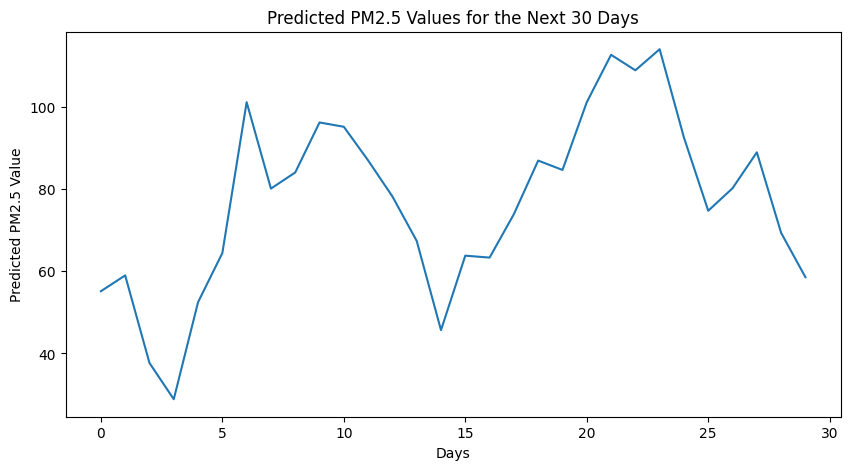

In [46]:
# Plot the predictions in the original scale
plt.figure(figsize=(10, 5))
plt.plot(predictions)
plt.title('Predicted PM2.5 Values for the Next 30 Days')
plt.xlabel('Days')
plt.ylabel('Predicted PM2.5 Value')
plt.show()